In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from models.architectures.temperature_prediction.simple_model import ModelSimple
from models.architectures.temperature_prediction.model_v2 import Modelv2
from models.architectures.temperature_prediction.model_v3 import Modelv3
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import Dataset, DataLoader

In [82]:
df = pd.read_csv("Data/data_concatenated/Albuquerque_concatenated.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             45253 non-null  datetime64[ns]
 1   humidity             44543 non-null  float64       
 2   pressure             44797 non-null  float64       
 3   temperature          45252 non-null  float64       
 4   weather_description  45252 non-null  object        
 5   wind_direction       45252 non-null  float64       
 6   wind_speed           45249 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.4+ MB


In [83]:
df

,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,50.0,1024.0,285.120000,sky is clear,360.0,4.0
2,2012-10-01 14:00:00,49.0,1024.0,285.154558,sky is clear,360.0,4.0
3,2012-10-01 15:00:00,49.0,1024.0,285.233952,sky is clear,360.0,4.0
4,2012-10-01 16:00:00,49.0,1024.0,285.313345,sky is clear,360.0,4.0
...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,37.0,1025.0,285.720000,broken clouds,217.0,1.0
45249,2017-11-29 21:00:00,34.0,1024.0,286.450000,broken clouds,217.0,1.0
45250,2017-11-29 22:00:00,32.0,1024.0,286.440000,broken clouds,190.0,1.0
45251,2017-11-29 23:00:00,30.0,1024.0,286.140000,overcast clouds,200.0,1.0


<Axes: xlabel='hour', ylabel='temperature'>

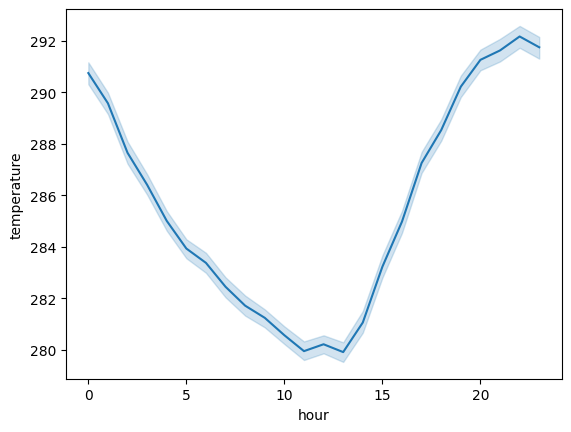

In [84]:
df["hour"] = df["datetime"].dt.hour
sns.lineplot(df, x="hour", y="temperature")

<Axes: xlabel='hour', ylabel='wind_speed'>

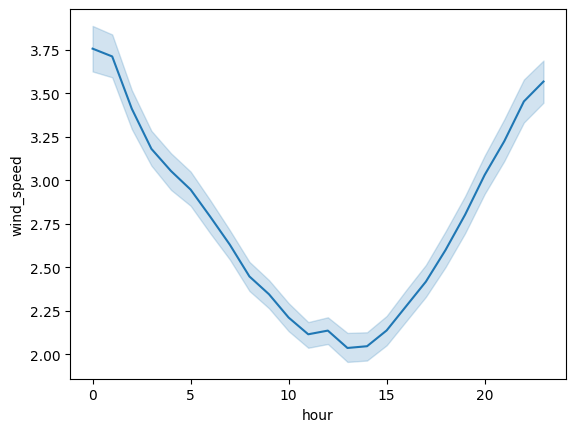

In [85]:
sns.lineplot(df, x="hour", y="wind_speed")

In [86]:
df["date"] = pd.to_datetime(df["datetime"].dt.date)
df

,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,hour,date
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,12,2012-10-01
1,2012-10-01 13:00:00,50.0,1024.0,285.120000,sky is clear,360.0,4.0,13,2012-10-01
2,2012-10-01 14:00:00,49.0,1024.0,285.154558,sky is clear,360.0,4.0,14,2012-10-01
3,2012-10-01 15:00:00,49.0,1024.0,285.233952,sky is clear,360.0,4.0,15,2012-10-01
4,2012-10-01 16:00:00,49.0,1024.0,285.313345,sky is clear,360.0,4.0,16,2012-10-01
...,...,...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,37.0,1025.0,285.720000,broken clouds,217.0,1.0,20,2017-11-29
45249,2017-11-29 21:00:00,34.0,1024.0,286.450000,broken clouds,217.0,1.0,21,2017-11-29
45250,2017-11-29 22:00:00,32.0,1024.0,286.440000,broken clouds,190.0,1.0,22,2017-11-29
45251,2017-11-29 23:00:00,30.0,1024.0,286.140000,overcast clouds,200.0,1.0,23,2017-11-29


In [ ]:
cloud_cover_mapping = {
    "overcast clouds": 0.9,
    "broken clouds": 0.75,
    "scattered clouds": 0.4,
    "few clouds": 0.2,
    "sky is clear": 0.0
}
df['cloud_cover'] = df['weather_description'].map(cloud_cover_mapping).fillna(1.0)

precipitation_mapping = {
    "thunderstorm": 4.0,
    "thunderstorm with rain": 5.0,
    "proximity thunderstorm": 1.0,
    "light rain": 2.0,
    "moderate rain": 2.5,
    "shower rain": 3.0,
    "light intensity shower rain": 2.5,
    "heavy intensity rain": 4.5,
    "heavy snow": 4.0,
    "light snow": 2.0,
    "drizzle": 2.0,
    "light intensity drizzle": 1.5,
    "heavy intensity drizzle": 2.5
}

df['rain_cover'] = df['weather_description'].map(precipitation_mapping).fillna(0.0)

df

,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,hour,date,cloud_cover
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,12,2012-10-01,1.00
1,2012-10-01 13:00:00,50.0,1024.0,285.120000,sky is clear,360.0,4.0,13,2012-10-01,0.00
2,2012-10-01 14:00:00,49.0,1024.0,285.154558,sky is clear,360.0,4.0,14,2012-10-01,0.00
3,2012-10-01 15:00:00,49.0,1024.0,285.233952,sky is clear,360.0,4.0,15,2012-10-01,0.00
4,2012-10-01 16:00:00,49.0,1024.0,285.313345,sky is clear,360.0,4.0,16,2012-10-01,0.00
...,...,...,...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,37.0,1025.0,285.720000,broken clouds,217.0,1.0,20,2017-11-29,0.75
45249,2017-11-29 21:00:00,34.0,1024.0,286.450000,broken clouds,217.0,1.0,21,2017-11-29,0.75
45250,2017-11-29 22:00:00,32.0,1024.0,286.440000,broken clouds,190.0,1.0,22,2017-11-29,0.75
45251,2017-11-29 23:00:00,30.0,1024.0,286.140000,overcast clouds,200.0,1.0,23,2017-11-29,0.90


In [88]:
df = df.drop([df.index[0], df.index[-1]])
df = df.drop(columns=['weather_description'])
df = df.groupby(by="date").mean().drop(columns=["datetime"]).reset_index()
df

,date,humidity,pressure,temperature,wind_direction,wind_speed,hour,cloud_cover
0,2012-10-01,48.909091,1024.000000,285.476208,360.000000,4.000000,18.0,0.000000
1,2012-10-02,40.363636,1022.772727,289.771821,303.458333,3.166667,11.5,0.025000
2,2012-10-03,31.904762,1021.666667,291.205417,132.708333,2.958333,11.5,0.025000
3,2012-10-04,19.681818,1018.318182,293.096250,144.541667,1.916667,11.5,0.108333
4,2012-10-05,18.250000,1020.850000,292.829167,225.875000,2.583333,11.5,0.108333
...,...,...,...,...,...,...,...,...
1881,2017-11-25,31.416667,1021.958333,282.564583,211.375000,2.166667,11.5,0.200000
1882,2017-11-26,29.750000,1027.166667,282.211250,194.333333,1.541667,11.5,0.337500
1883,2017-11-27,29.041667,1021.250000,281.325833,168.458333,1.708333,11.5,0.287500
1884,2017-11-28,31.458333,1016.125000,283.251667,227.500000,3.708333,11.5,0.279167


<Axes: xlabel='day_of_year', ylabel='temperature'>

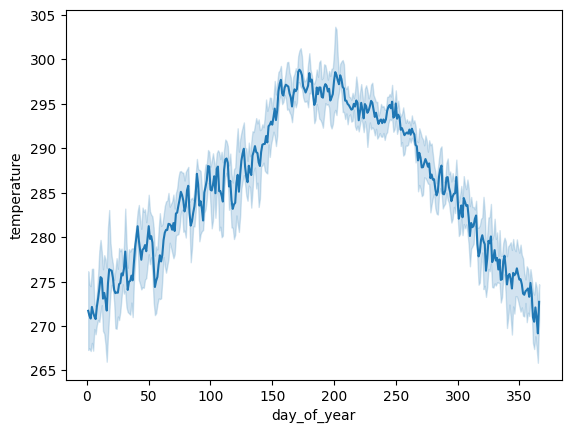

In [8]:
df["day_of_year"] = df["date"].dt.day_of_year
sns.lineplot(df, x="day_of_year", y="temperature")

<Axes: xlabel='wind_speed', ylabel='temperature'>

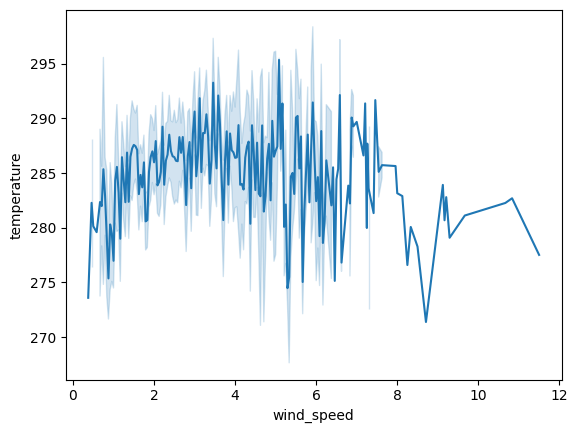

In [9]:
sns.lineplot(df, x="wind_speed", y="temperature")

<Axes: xlabel='humidity', ylabel='temperature'>

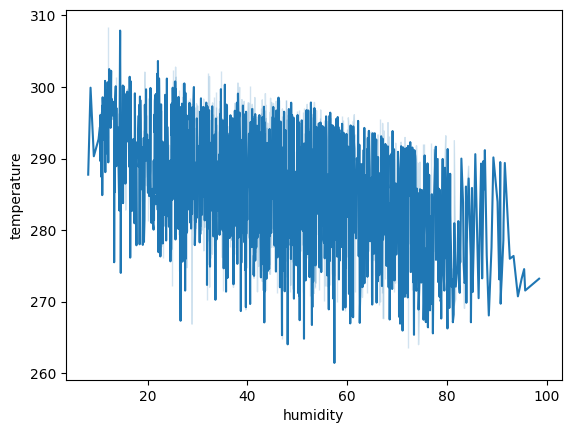

In [10]:
sns.lineplot(df, x="humidity", y="temperature")

<Axes: xlabel='day_of_year', ylabel='humidity'>

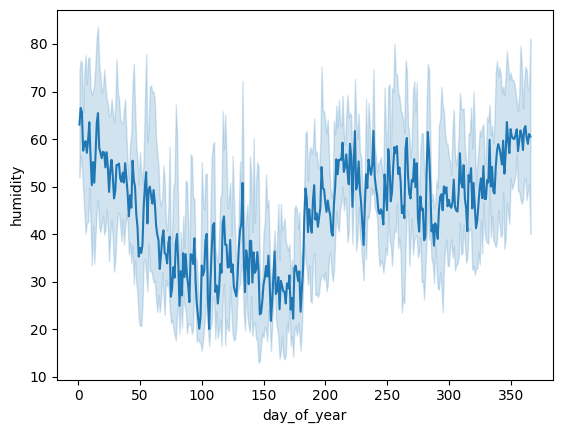

In [11]:
sns.lineplot(df, x="day_of_year", y="humidity")

<Axes: xlabel='day_of_year', ylabel='wind_speed'>

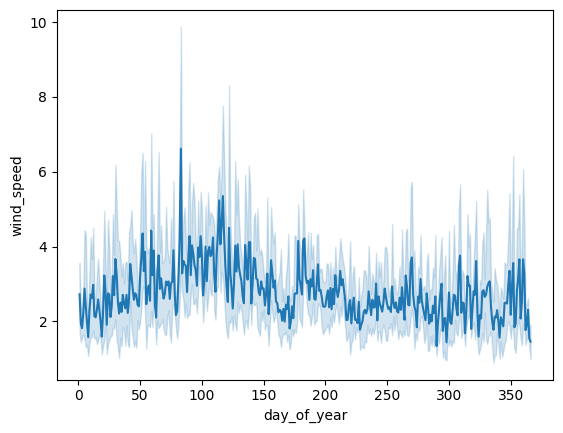

In [12]:
sns.lineplot(df, x="day_of_year", y="wind_speed")

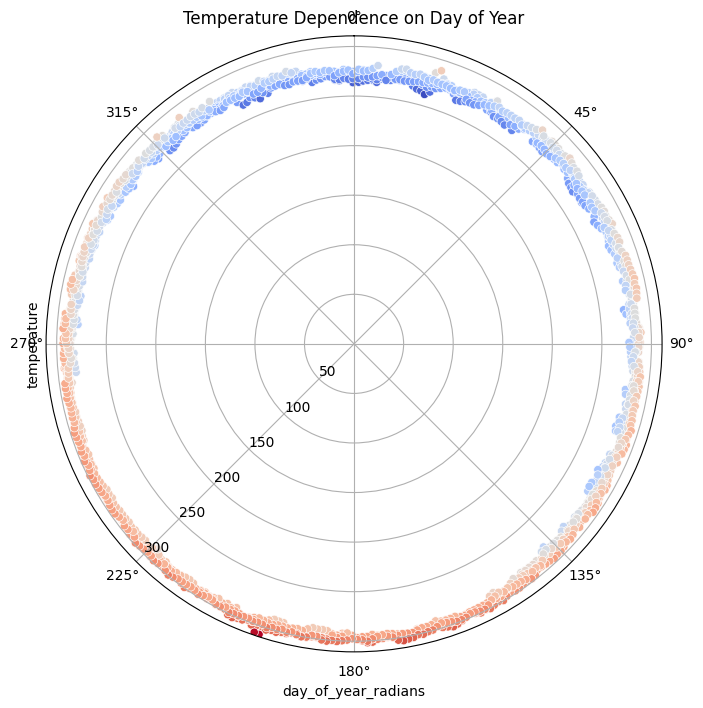

In [13]:
df["day_of_year_radians"] = 2 * np.pi * df["day_of_year"] / 365.25
# Create the polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)  # Set the plot to polar
# Scatter plot
sns.scatterplot(
    x=df['day_of_year_radians'], 
    y=df['temperature'], 
    hue=df['temperature'], 
    palette='coolwarm', 
    ax=ax, 
    legend=None
)
# Aesthetic adjustments
ax.set_theta_direction(-1)  # Reverse direction to match day cycle
ax.set_theta_offset(np.pi / 2)  # Set day 1 to the top
ax.set_rlabel_position(225)  # Adjust radial labels
ax.set_title("Temperature Dependence on Day of Year", va='bottom')

# Show the plot
plt.show()



<Axes: xlabel='day_of_year_sin', ylabel='day_of_year_cos'>

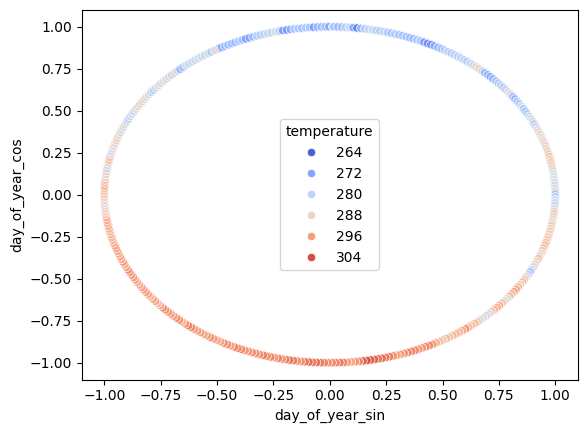

In [14]:
df['day_of_year_sin'] = np.sin(df["day_of_year_radians"])
df['day_of_year_cos'] = np.cos(df["day_of_year_radians"])

sns.scatterplot(df, x="day_of_year_sin", y="day_of_year_cos", hue="temperature", palette='coolwarm', )

In [15]:
df

,date,humidity,pressure,temperature,wind_direction,wind_speed,hour,day_of_year,day_of_year_radians,day_of_year_sin,day_of_year_cos
0,2012-10-01,48.909091,1024.000000,285.476208,360.000000,4.000000,17.5,275,4.730667,-0.999833,0.018277
1,2012-10-02,40.363636,1022.772727,289.771821,303.458333,3.166667,11.5,276,4.747869,-0.999371,0.035473
2,2012-10-03,31.904762,1021.666667,291.205417,132.708333,2.958333,11.5,277,4.765071,-0.998613,0.052658
3,2012-10-04,19.681818,1018.318182,293.096250,144.541667,1.916667,11.5,278,4.782274,-0.997559,0.069828
4,2012-10-05,18.250000,1020.850000,292.829167,225.875000,2.583333,11.5,279,4.799476,-0.996210,0.086977
...,...,...,...,...,...,...,...,...,...,...,...
1882,2017-11-26,29.750000,1027.166667,282.211250,194.333333,1.541667,11.5,330,5.676800,-0.569901,0.821713
1883,2017-11-27,29.041667,1021.250000,281.325833,168.458333,1.708333,11.5,331,5.694002,-0.555682,0.831395
1884,2017-11-28,31.458333,1016.125000,283.251667,227.500000,3.708333,11.5,332,5.711205,-0.541298,0.840831
1885,2017-11-29,52.000000,1026.458333,277.646250,227.291667,3.625000,11.5,333,5.728407,-0.526755,0.850017


In [16]:
df_proposition = df
df_proposition = df_proposition.drop(columns = ['day_of_year', 'day_of_year_radians', 'hour', 'date', 'wind_direction'])
df_proposition



,humidity,pressure,temperature,wind_speed,day_of_year_sin,day_of_year_cos
0,48.909091,1024.000000,285.476208,4.000000,-0.999833,0.018277
1,40.363636,1022.772727,289.771821,3.166667,-0.999371,0.035473
2,31.904762,1021.666667,291.205417,2.958333,-0.998613,0.052658
3,19.681818,1018.318182,293.096250,1.916667,-0.997559,0.069828
4,18.250000,1020.850000,292.829167,2.583333,-0.996210,0.086977
...,...,...,...,...,...,...
1882,29.750000,1027.166667,282.211250,1.541667,-0.569901,0.821713
1883,29.041667,1021.250000,281.325833,1.708333,-0.555682,0.831395
1884,31.458333,1016.125000,283.251667,3.708333,-0.541298,0.840831
1885,52.000000,1026.458333,277.646250,3.625000,-0.526755,0.850017


In [17]:
df_proposition['target_temperature'] = df_proposition['temperature'].shift(-4)
df_proposition

,humidity,pressure,temperature,wind_speed,day_of_year_sin,day_of_year_cos,target_temperature
0,48.909091,1024.000000,285.476208,4.000000,-0.999833,0.018277,292.829167
1,40.363636,1022.772727,289.771821,3.166667,-0.999371,0.035473,292.885417
2,31.904762,1021.666667,291.205417,2.958333,-0.998613,0.052658,288.764792
3,19.681818,1018.318182,293.096250,1.916667,-0.997559,0.069828,281.987500
4,18.250000,1020.850000,292.829167,2.583333,-0.996210,0.086977,284.581667
...,...,...,...,...,...,...,...
1882,29.750000,1027.166667,282.211250,1.541667,-0.569901,0.821713,284.700000
1883,29.041667,1021.250000,281.325833,1.708333,-0.555682,0.831395,NaN
1884,31.458333,1016.125000,283.251667,3.708333,-0.541298,0.840831,NaN
1885,52.000000,1026.458333,277.646250,3.625000,-0.526755,0.850017,NaN


In [18]:
# List of features to process
# TODO: dodać wind_direction zamieniony na cos i sin
# TODO: dodać może zmianę średniej temperatury, ciśnienia (wiatr może się zmieniać kompletnie z dnia na dzień) (wilgotność nawet z godziny na godzinę potrafi się zmienić)
features_to_expand = ['humidity', 'pressure', 'temperature', 'wind_speed']

# Create shifted columns for each feature
for feature in features_to_expand:
    df_proposition[f'{feature}_1'] = df_proposition[feature]
    df_proposition[f'{feature}_2'] = df_proposition[feature].shift(-1)
    df_proposition[f'{feature}_3'] = df_proposition[feature].shift(-2)

# Drop the original columns that were expanded
df_proposition = df_proposition.drop(columns=features_to_expand)

df_proposition = df_proposition[:-4]

df_proposition

,day_of_year_sin,day_of_year_cos,target_temperature,humidity_1,humidity_2,humidity_3,pressure_1,pressure_2,pressure_3,temperature_1,temperature_2,temperature_3,wind_speed_1,wind_speed_2,wind_speed_3
0,-0.999833,0.018277,292.829167,48.909091,40.363636,31.904762,1024.000000,1022.772727,1021.666667,285.476208,289.771821,291.205417,4.000000,3.166667,2.958333
1,-0.999371,0.035473,292.885417,40.363636,31.904762,19.681818,1022.772727,1021.666667,1018.318182,289.771821,291.205417,293.096250,3.166667,2.958333,1.916667
2,-0.998613,0.052658,288.764792,31.904762,19.681818,18.250000,1021.666667,1018.318182,1020.850000,291.205417,293.096250,292.829167,2.958333,1.916667,2.583333
3,-0.997559,0.069828,281.987500,19.681818,18.250000,19.238095,1018.318182,1020.850000,1020.318182,293.096250,292.829167,292.885417,1.916667,2.583333,3.333333
4,-0.996210,0.086977,284.581667,18.250000,19.238095,29.695652,1020.850000,1020.318182,1003.416667,292.829167,292.885417,288.764792,2.583333,3.333333,2.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,-0.625050,0.780585,282.211250,41.375000,42.625000,45.250000,1028.333333,1026.625000,1020.250000,280.648750,281.507083,281.715417,3.000000,1.416667,1.333333
1879,-0.611530,0.791221,281.325833,42.625000,45.250000,31.416667,1026.625000,1020.250000,1021.958333,281.507083,281.715417,282.564583,1.416667,1.333333,2.166667
1880,-0.597829,0.801624,283.251667,45.250000,31.416667,29.750000,1020.250000,1021.958333,1027.166667,281.715417,282.564583,282.211250,1.333333,2.166667,1.541667
1881,-0.583951,0.811789,277.646250,31.416667,29.750000,29.041667,1021.958333,1027.166667,1021.250000,282.564583,282.211250,281.325833,2.166667,1.541667,1.708333


In [19]:
#normalize all the values
scaler = MinMaxScaler()

normalized_df = pd.DataFrame(scaler.fit_transform(df_proposition), columns=df_proposition.columns)
normalized_df

,day_of_year_sin,day_of_year_cos,target_temperature,humidity_1,humidity_2,humidity_3,pressure_1,pressure_2,pressure_3,temperature_1,temperature_2,temperature_3,wind_speed_1,wind_speed_2,wind_speed_3
0,0.000083,0.509136,0.668474,0.451428,0.356899,0.263327,0.885861,0.880340,0.875365,0.511797,0.603328,0.633875,0.325843,0.250936,0.232210
1,0.000314,0.517734,0.669672,0.356899,0.263327,0.128117,0.880340,0.875365,0.860303,0.603328,0.633875,0.674165,0.250936,0.232210,0.138577
2,0.000693,0.526327,0.581870,0.263327,0.128117,0.112279,0.875365,0.860303,0.871692,0.633875,0.674165,0.668474,0.232210,0.138577,0.198502
3,0.001220,0.534912,0.437460,0.128117,0.112279,0.123209,0.860303,0.871692,0.869300,0.674165,0.668474,0.669672,0.138577,0.198502,0.265918
4,0.001895,0.543486,0.492737,0.112279,0.123209,0.238890,0.871692,0.869300,0.793275,0.668474,0.669672,0.581870,0.198502,0.265918,0.161049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,0.187476,0.890295,0.442228,0.368086,0.381914,0.410951,0.905353,0.897668,0.868993,0.408934,0.427224,0.431663,0.235955,0.093633,0.086142
1879,0.194236,0.895614,0.423362,0.381914,0.410951,0.257928,0.897668,0.868993,0.876677,0.427224,0.431663,0.449757,0.093633,0.086142,0.161049
1880,0.201087,0.900815,0.464397,0.410951,0.257928,0.239491,0.868993,0.876677,0.900105,0.431663,0.449757,0.442228,0.086142,0.161049,0.104869
1881,0.208026,0.905897,0.344957,0.257928,0.239491,0.231656,0.876677,0.900105,0.873491,0.449757,0.442228,0.423362,0.161049,0.104869,0.119850


In [20]:
class WeatherDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [21]:
data = normalized_df.drop(columns=['target_temperature']).to_numpy()
targets = normalized_df['target_temperature'].to_numpy()

# Split data into training and testing
train_data, test_data = data[:1400], data[1400:]
train_targets, test_targets = targets[:1400], targets[1400:]

# Create dataset and data loaders
train_dataset = WeatherDataset(train_data, train_targets)
test_dataset = WeatherDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

ModelSimple

In [22]:
# Number of features
input_size = data.shape[1] 

# Initialize the model
model = ModelSimple(input_size=input_size)

# Train the model
model.train_model(train_loader, epochs=20)

# Evaluate the model on the test set
model.test_model(test_loader)

# Make prediction
tested_row = -3
prediction = model.predict(torch.tensor(data[tested_row], dtype=torch.float32).unsqueeze(0))

max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

unnormalized_prediction = prediction * (max_value-min_value) + min_value
unnormalized_target = test_targets[tested_row] * (max_value-min_value) + min_value
print(f"Predicted temperature: {unnormalized_prediction}")
print(f"Target temperature: {unnormalized_target}")

Epoch 1/20, Loss: 0.0420
Epoch 10/20, Loss: 0.0045
Epoch 20/20, Loss: 0.0044
Test Loss: 0.0043
Predicted temperature: 280.94813275422405
Target temperature: 283.25166666666667


Model v2

In [23]:
# Number of features
input_size = data.shape[1] 

# Initialize the model
model = Modelv2(input_size=input_size)

# Train the model
model.train_model(train_loader, epochs=25)

# Evaluate the model on the test set
model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)

# Optionally, convert the differences into a NumPy array or Tensor
absolute_differences = torch.tensor(absolute_differences)

# Print summary
print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/25, Loss: 0.0951
Epoch 10/25, Loss: 0.0048
Epoch 20/25, Loss: 0.0042
Test Loss: 0.0042
Mean Absolute Difference: 2.4611505446786826


In [30]:
# Number of features
input_size = data.shape[1] 

# Initialize the model
model = Modelv3(input_size=input_size)

# Train the model
model.train_model(train_loader, epochs=30)

# Evaluate the model on the test set
model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)

# Optionally, convert the differences into a NumPy array or Tensor
absolute_differences = torch.tensor(absolute_differences)

# Print summary
print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/30, Loss: 0.0605
Epoch 10/30, Loss: 0.0044
Epoch 20/30, Loss: 0.0040
Epoch 30/30, Loss: 0.0039
Test Loss: 0.0039
Mean Absolute Difference: 2.3734429333572042


Tylko temperatura

In [80]:
df_only_temperature = df
df_only_temperature = df_only_temperature.drop(columns = ['day_of_year', 'day_of_year_radians', 'hour', 'date', 'wind_direction', 'wind_speed', 'pressure', 'humidity' ])
df_only_temperature['target_temperature'] = df_only_temperature['temperature'].shift(-4)
features_to_expand = ['temperature']

# Create shifted columns for each feature
for feature in features_to_expand:
    df_only_temperature[f'{feature}_1'] = df_only_temperature[feature]
    df_only_temperature[f'{feature}_2'] = df_only_temperature[feature].shift(-1)
    df_only_temperature[f'{feature}_3'] = df_only_temperature[feature].shift(-2)

# Drop the original columns that were expanded
df_only_temperature = df_only_temperature.drop(columns=features_to_expand)

df_only_temperature = df_only_temperature[:-4]

#normalize all the values
scaler = MinMaxScaler()

df_only_temperature = pd.DataFrame(scaler.fit_transform(df_only_temperature), columns=df_only_temperature.columns)

df_only_temperature

,day_of_year_sin,day_of_year_cos,target_temperature,temperature_1,temperature_2,temperature_3
0,0.000083,0.509136,0.668474,0.511797,0.603328,0.633875
1,0.000314,0.517734,0.669672,0.603328,0.633875,0.674165
2,0.000693,0.526327,0.581870,0.633875,0.674165,0.668474
3,0.001220,0.534912,0.437460,0.674165,0.668474,0.669672
4,0.001895,0.543486,0.492737,0.668474,0.669672,0.581870
...,...,...,...,...,...,...
1878,0.187476,0.890295,0.442228,0.408934,0.427224,0.431663
1879,0.194236,0.895614,0.423362,0.427224,0.431663,0.449757
1880,0.201087,0.900815,0.464397,0.431663,0.449757,0.442228
1881,0.208026,0.905897,0.344957,0.449757,0.442228,0.423362


In [81]:
data_only_temp = df_only_temperature.drop(columns=['target_temperature']).to_numpy()
targets_only_temp = df_only_temperature['target_temperature'].to_numpy()

# Split data into training and testing
train_data, test_data = data_only_temp[:1400], data_only_temp[1400:]
train_targets, test_targets = targets_only_temp[:1400], targets_only_temp[1400:]

# Create dataset and data loaders
train_dataset = WeatherDataset(train_data, train_targets)
test_dataset = WeatherDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Number of features
input_size = data_only_temp.shape[1] 

# Initialize the model
model = Modelv2(input_size=input_size)

# Train the model
model.train_model(train_loader, epochs=30)

# Evaluate the model on the test set
model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)

# Optionally, convert the differences into a NumPy array or Tensor
absolute_differences = torch.tensor(absolute_differences)

# Print summary
print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/30, Loss: 0.0990
Epoch 10/30, Loss: 0.0050
Epoch 20/30, Loss: 0.0047
Epoch 30/30, Loss: 0.0048
Test Loss: 0.0048
Mean Absolute Difference: 2.6336116124812814
